In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("asm_full_opt")
from phase_mask import PhaseMask
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
from im_postprocess import PostProcess
import config

In [2]:
asm = ASMPropagator(config)

phase = PhaseMask(
    config,
    num_masks=16,
    init="hyperbolic",
    # defocus_max=20e-6,
    X=asm.X,
    Y=asm.Y,    
    test_orientation=True,
)

with torch.no_grad():
    psfs, Uz = asm(phase_mask=phase, normalize=True, return_field=True)

print(Uz.shape)
print(psfs.shape)

torch.Size([16, 255, 255])
torch.Size([16, 255, 255])


Loaded batch: torch.Size([10, 28, 28])
Labels (first 10): [3, 1, 1, 0, 4, 9, 2, 0, 0, 2]


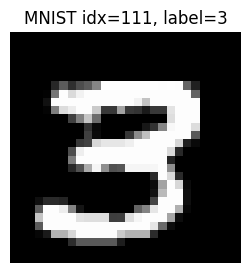

In [3]:
import torch
from torchvision.datasets import MNIST

ds = MNIST(root="./data", train=True, download=False)

# Choose how many images to batch
N_batch = 10
idx0 = 111   # starting index

# Stack N_batch images into a batch
objs = []
labels = []
for i in range(N_batch):
    x_pil, y = ds[idx0 + i]
    objs.append(torch.from_numpy(np.array(x_pil)).float() / 255.0)
    labels.append(y)

objs = torch.stack(objs, dim=0)   # [N,28,28]

print("Loaded batch:", objs.shape)
print("Labels (first 10):", labels[:10])

# Show ONE image from the batch
show_idx = 0
plt.figure(figsize=(3,3))
plt.imshow(objs[show_idx], cmap="gray", vmin=0, vmax=1)
plt.title(f"MNIST idx={idx0+show_idx}, label={labels[show_idx]}")
plt.axis("off")
plt.show()


In [4]:
pm = PixelMap(config, asm.X, asm.Y)

conv = PSFConv(config, pm, asm.X, asm.Y)

imgs = conv.sensor_image(objs, psfs)

print(imgs.shape)

torch.Size([10, 16, 255, 255])


In [5]:
pp = PostProcess(config, pixel_map=pm, X=asm.X, Y=asm.Y).to(conv.device_ if hasattr(conv, "device_") else ("cuda" if torch.cuda.is_available() else "cpu"))

# crop_box = pp.compute_img_crop()
imgs_crop = pp.crop_imgs(imgs)
print("imgs_crop shape:", imgs_crop.shape)


imgs_crop shape: torch.Size([10, 16, 49, 49])


imgs_ds shape: torch.Size([10, 16, 28, 28])


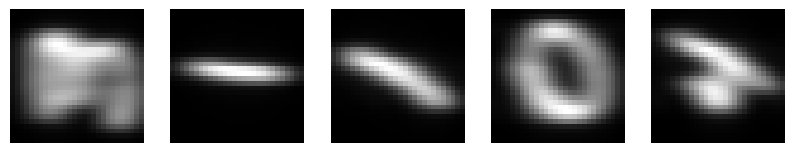

In [6]:
imgs_ds = pp.downsample_imgs(imgs_crop)
print("imgs_ds shape:", imgs_ds.shape)

fig, ax = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    ax[i].imshow(imgs_ds[i, 0].detach().cpu(), cmap="gray")
    ax[i].axis("off")
plt.show()

fm shape: torch.Size([10, 8, 28, 28])


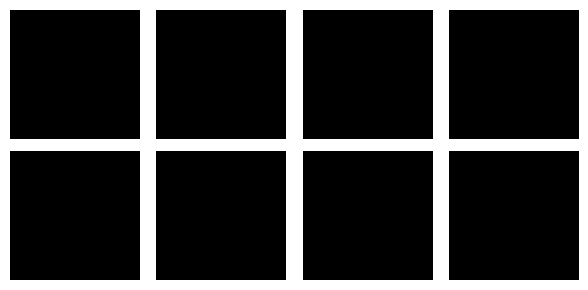

In [7]:
fm = pp.subtract_imgs(imgs_ds)
print("fm shape:", fm.shape)

fig, ax = plt.subplots(2, 4, figsize=(6, 3))
for k in range(8):
    ax[k//4, k%4].imshow(fm[0, k], cmap="gray")
    ax[k//4, k%4].axis("off")
plt.tight_layout()

In [11]:
imgs_pp = pp(imgs, subtract=False)
print("imgs_pp shape:", imgs_pp.shape)

imgs_pp shape: torch.Size([10, 16, 28, 28])


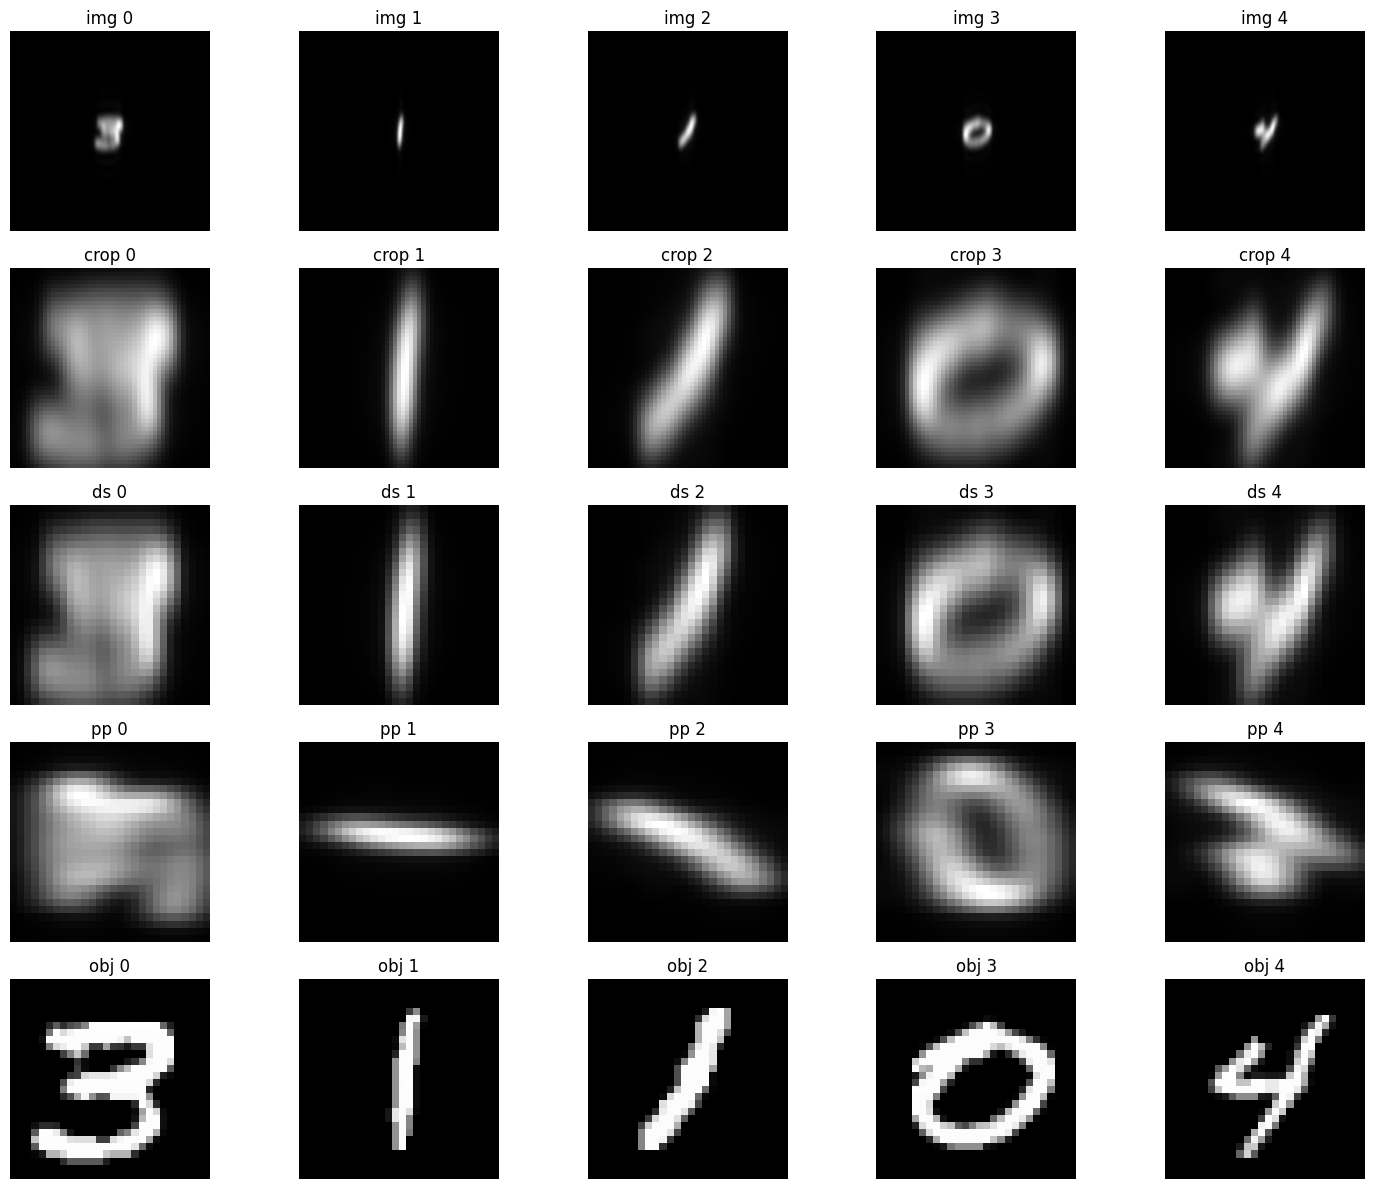

In [12]:
import matplotlib.pyplot as plt

ch = 1
num = 5

# Handle obj shape
if objs.ndim == 4:
    obj_plot = objs[:, 0]   # [B,H,W]
elif objs.ndim == 3:
    obj_plot = objs         # [B,H,W]
else:
    raise ValueError(f"Unexpected obj shape: {obj.shape}")

fig, axes = plt.subplots(5, num, figsize=(3*num, 12))

for i in range(num):
    # Row 0: original imgs
    axes[0, i].imshow(
        imgs[i, ch].T.flip(0).flip(1).detach().cpu(),
        cmap="gray",
        origin="lower"
    )
    axes[0, i].set_title(f"img {i}")
    axes[0, i].axis("off")

    # Row 1: cropped imgs
    axes[1, i].imshow(
        imgs_crop[i, ch].T.flip(0).flip(1).detach().cpu(),
        cmap="gray",
        origin="lower"
    )
    axes[1, i].set_title(f"crop {i}")
    axes[1, i].axis("off")

    # Row 2: downsampled imgs
    axes[2, i].imshow(
        imgs_ds[i, ch].T.flip(0).flip(1).detach().cpu(),
        cmap="gray",
        origin="lower"
    )
    axes[2, i].set_title(f"ds {i}")
    axes[2, i].axis("off")

    # Row 3: downsampled imgs
    axes[3, i].imshow(
        imgs_pp[i, ch].detach().cpu(),
        cmap="gray",
        # origin="lower"
    )
    axes[3, i].set_title(f"pp {i}")
    axes[3, i].axis("off")

    # Row 4: object (ground truth)
    axes[4, i].imshow(
        obj_plot[i].detach().cpu(),
        cmap="gray",
        # origin="lower"
    )
    axes[4, i].set_title(f"obj {i}")
    axes[4, i].axis("off")

axes[0, 0].set_ylabel("imgs", fontsize=12)
axes[1, 0].set_ylabel("imgs_crop", fontsize=12)
axes[2, 0].set_ylabel("imgs_ds", fontsize=12)
axes[3, 0].set_ylabel("imgs_pp", fontsize=12)
axes[4, 0].set_ylabel("obj", fontsize=12)

plt.tight_layout()
plt.show()
